# <center> PROJECT-3 EDA + Feature Engineering. Соревнование на kaggle


<center> <img src = image\images.jpg alt="drawing" style="width:300px;">

##  РЕЙТИНГИ ОТЕЛЕЙ НА BOOKING

## 1. Введение 

### Какой кейс решаем?

Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.
    
Первоначальная версия датасета содержит 17 полей со следующей информацией:</p>

**hotel_address** — адрес отеля;<br>
**review_date** — дата, когда рецензент разместил соответствующий отзыв;<br>
**average_score** — средний балл отеля, рассчитанный на основе последнего комментария за последний год;<br>
**hotel_name** — название отеля;<br>
**reviewer_nationality** — страна рецензента;<br>
**negative_review** — отрицательный отзыв, который рецензент дал отелю;<br>
**review_total_negative_word_counts** — общее количество слов в отрицательном отзыв;<br>
**positive_review — положительный отзыв**, который рецензент дал отелю;<br>
**review_total_positive_word_counts** — общее количество слов в положительном отзыве.<br>
**reviewer_score** — оценка, которую рецензент поставил отелю на основе своего опыта;<br>
**total_number_of_reviews_reviewer_has_given** — количество отзывов, которые рецензенты дали в прошлом;<br>
**total_number_of_reviews** — общее количество действительных отзывов об отеле;<br>
**tags** — теги, которые рецензент дал отелю;<br>
**days_since_review** — количество дней между датой проверки и датой очистки;<br>
**additional_number_of_scoring** — есть также некоторые гости, которые просто поставили оценку сервису, но не<br> оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.<br>
**lat** — географическая широта отеля;<br>
**lng** — географическая долгота отеля.<br>

## 1.1 Подготовка и чтение данных

In [1]:
import numpy as np 
import pandas as pd 

# импорт специальных библиотек
from collections import Counter
import geopy.distance
import category_encoders as ce
from sklearn import preprocessing
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor  
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# инструменты для лингвистического анализа:
import nltk  
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer  
nltk.download('vader_lexicon')

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\uplot\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
df_train = pd.read_csv('data_kaggle/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data_kaggle/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data_kaggle/submission.csv') # самбмишн

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [10]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [12]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [13]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [14]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [6]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\uplot\AppData\Local\Temp\ipykernel_5476\154621427.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [7]:
# ищем в столбцах данные, содержащие пропущенные значения
data.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64

После чтения и визуальной оценки данных, видим, что отсутствуют по 3268 значения в столбцах *lat* и *lng*. 

*Числовые значения* представлены в 9 столбцах: 'additional_number_of_scoring', 'average_score','review_total_negative_word_counts','total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews', 'review_total_positive_word_counts', 'reviewer_scoretotal_number_of_reviews_reviewer_has_given', 'lat', 'lng'. 

*Значения типа object* представлены в 8 столбцах: 'hotel_address', review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', ' tags ', 'days_since_review'.

## 2. Проектирование признаков

## 2.1. Преобразование признака *hotel_address*

Из данного признака можно выделить два новых: страна и город отеля. 
Страна в строке указана последней, Англия образуется как '*Kingdom*' - переименуем её '*United Kingdom*';
Город - это второе слово с конца, Англия - пятое с конца.

In [8]:
# представленыые значения
data['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

In [9]:
# создаем признак страны
def get_country(address):
    # разделяем строку на слова, создаем список слов
    address_list = address.split(' ')
    # является ли страна UK
    if address_list[-1] == 'Kingdom':
        country = 'United Kingdom' 
    else:
        country = address_list[-1]

    return country

In [10]:
# создаем признак города
def get_city(address):
    # разделяем строку на слова, создаем список слов
    address_list = address.split(' ')
    # является ли страна UK
    if address_list[-1] == 'Kingdom':
        city = address_list[-5]
    else:
        city = address_list[-2]
    
    return city

In [11]:
# признак страны
data['country'] = data['hotel_address'].apply(get_country)

# признак города
data['city'] = data['hotel_address'].apply(get_city)

In [12]:
print(data['country'].unique().tolist(), data['country'].nunique(), sep='\n')

['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France', 'Austria']
6


In [13]:
print(data['city'].unique().tolist(), data['city'].nunique(), sep='\n')

['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna']
6


In [14]:
# удаление признака адреса
data.drop('hotel_address', axis=1, inplace=True)

На основании этих двух новых признаков можно заполнить пропуски в *lat*, *lng* медианными значениями по городам, в которых находятся эти отели.

## 2.2. Преобразование признаков *lat*, *lng* (географических координат)

In [15]:
# копируем датафрейм
data_crds = data.copy()

# объект SeriesGroupBy
city_data = data_crds.groupby(['city'], group_keys=False)

# медианные координаты
city_data['lat'].median()
city_data['lng'].median()

# заменяем пропуски соответствующим медианным значением
data_crds['lat'] = city_data['lat'].apply(lambda x: x.fillna(x.median()))
data_crds['lng'] = city_data['lng'].apply(lambda x: x.fillna(x.median()))

# переносим результат в исходный датафрейм
data = data_crds

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

In [16]:
# проверяем на наличие пропущенных значений
data.isnull().sum()

additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
country                                       0
city                                          0
dtype: int64

In [27]:
# удаление столбцов с координатами
data.drop(['lng', 'lat'], axis=1, inplace=True) 

## 2.3. Преобразование признака даты *review_date*

In [17]:
# преобразуем формат признака даты в формат datetime
data['review_date'] = pd.to_datetime(data['review_date'], dayfirst=False)
# признак месяца
data['month'] = data['review_date'].dt.month
# определим, когда высокий сезон
data['month'].value_counts().nlargest(5)

8     50672
7     49318
5     46490
10    43843
6     42896
Name: month, dtype: int64

отнесем 8й, 7й, 5й месяцы к высокому сезону

In [18]:
# относится ли день написания отзыва к высокому сезону
data['high_season'] = data['month'].apply(lambda x: 1 if x in [5, 7, 8] else 0)

In [19]:
# функция определения сезона, когда создан отзыв
def get_season(month):
    if month in [1, 2, 12]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4
    
# создание признака сезона
data['season'] = data['month'].apply(get_season)

In [20]:
day_of_week = data['review_date'].dt.dayofweek

In [21]:
# функция определения, был ли день, когда оставили отзыв, выходным
def get_day_of_week(weekday):
    if weekday == 5 or weekday == 6:
        return 1
    else:
        return 0
    
data['weekend'] = day_of_week.apply(get_day_of_week)

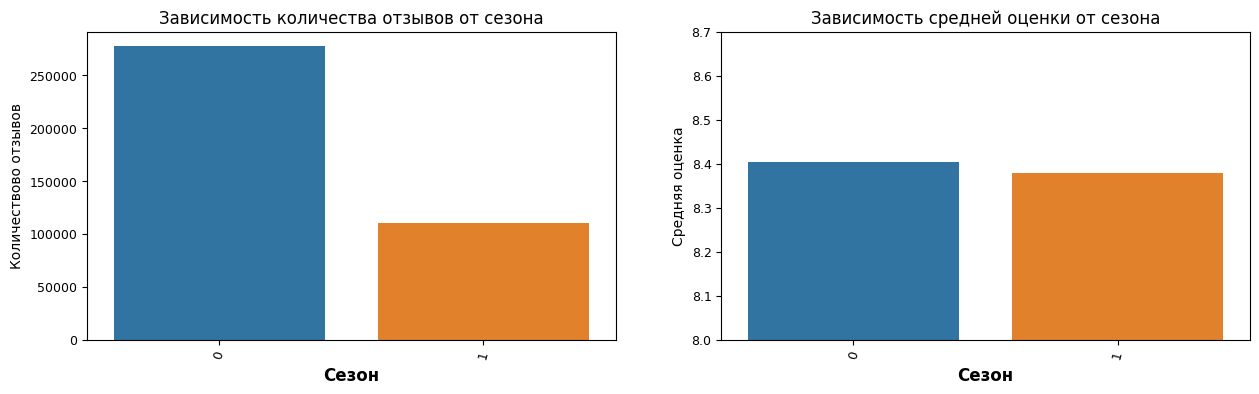

In [25]:
# данные для визулизации

period = data[data['sample']==1].pivot_table(
    values='reviewer_score',
    index='high_season',
    aggfunc=['mean', 'count']
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x=period.index, y=period[('count', 'reviewer_score')], ax=ax1);

ax1.set_title('Зависимость количества отзывов от сезона')
ax1.set_ylabel('Количествово отзывов');
ax1.tick_params(axis='x', rotation=75)


sns.barplot(x=period.index, y=period[('mean', 'reviewer_score')], ax=ax2);

ax2.set_title('Зависимость средней оценки от сезона')
ax2.set_ylabel('Средняя оценка');
ax2.tick_params(axis='x', rotation=75)

ax1.set_xlabel('Сезон', fontweight = 600, fontsize = 12);
ax2.set_xlabel('Сезон', fontweight = 600, fontsize = 12);

ax1.tick_params(axis='both', which='major', labelsize=9)
ax2.tick_params(axis='both', which='major', labelsize=9)

plt.ylim(8, 8.7)
plt.show()

Мы наблюдаем сезонные колебания оценок: в период высокого сезона их в 2 раза больше, а по средней оценке - она немного выше в высокий сезон.

In [26]:
# удаление признака даты
data.drop('review_date', axis=1, inplace=True) 

## 2.4. Преобразование признака страны рецензента *reviewer_nationality*

In [27]:
# количество стран, из которых едут туристы
data['reviewer_nationality'].nunique()

227

In [28]:
data['reviewer_nationality'].value_counts()

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64

Мы видим, что разброс очень большой: есть страны с 1 отзывом, и есть Великобритания (United Kingdom), на которую приходится около 60% всех отзывов. В свзи с этим, ограничимся топ-25 стран.

In [29]:
# 25 наиболее популярных
data['reviewer_nationality'].value_counts().nlargest(25)

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
 India                          3437
 Greece                         3406
 China                          3400
 Sweden                         3368
 New Zealand                    3237
Name: reviewer_nationality, dtype: int64

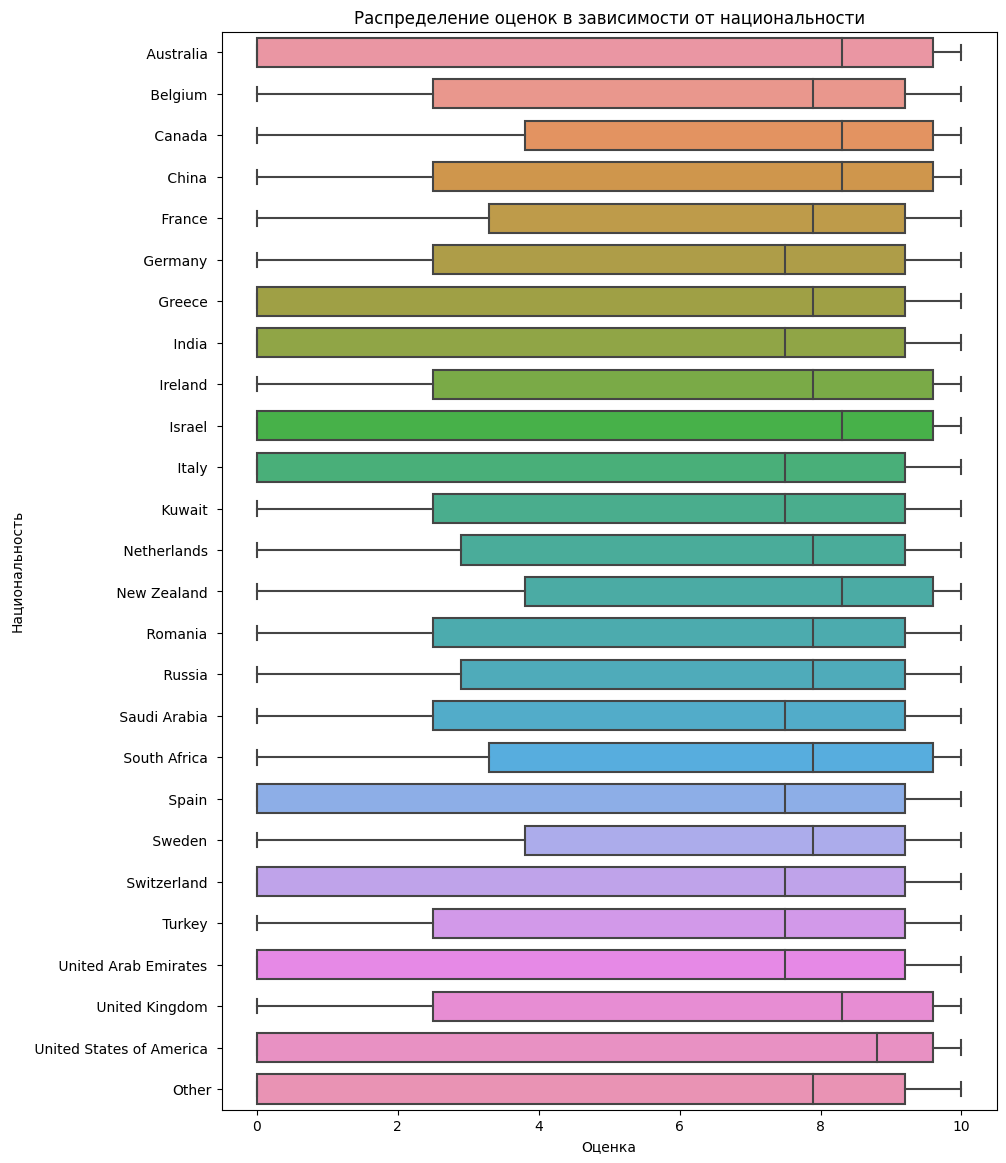

In [30]:
# оставляем только 25 наиболее путешествующих национальностей
top_25_tourist_nations = data['reviewer_nationality'].value_counts().nlargest(25).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(
    lambda x:x if x in top_25_tourist_nations else 'Other')

# посмотрим, зависит ли оценка от национальности
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 14))

nationality = sns.boxplot(
    data = data.sort_values(by='reviewer_nationality', ascending=True),
    y = 'reviewer_nationality',
    x = 'reviewer_score',
    orient ='h',
    width = 0.7
)

nationality.set(xlabel='Оценка', ylabel='Национальность', title='Распределение оценок в зависимости от национальности');

На графике видно, что наибольший диапазон оценок у Саудовской Аравии и ОАЭ. Наивысшая медиана оценок у Великобритании, США, Канады и Австралии. 
Данный признак пока не удаляем для дальнейшего его кодирования.

## 2.5. Преобразование признака *negative_review*


In [31]:
# приведем строки к единообразию
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip().lower())
# выведем 50 самых популярных отзывов
data['negative_review'].value_counts().nlargest(50)


no negative                       127890
nothing                            21185
n a                                 1815
none                                1501
                                     849
nothing really                       656
small room                           570
all good                             545
breakfast                            545
no complaints                        523
location                             502
nothing at all                       467
everything                           420
nothing to dislike                   373
price                                348
nil                                  332
small rooms                          307
everything was perfect               276
na                                   272
can t think of anything              250
leaving                              244
absolutely nothing                   242
everything was great                 222
expensive                            206
nothing to compl

In [32]:
# В некоторых негативных отзывах указано "нет негатива", пометим их и создадим соответствующий признак 
# (из тех, которые встречаются более 150 раз, остальное - незначительно)

no_negative_review = ['no negative', 'nothing', 'n a', 'none', '', ' ', 'all good', 'no complaints', 'everything was perfect', \
    'na', 'everything was great', 'nothing to complain about', 'no', 'i liked everything', 'everything was good']

# создадим признак того, является ли отзыв отрицательным
data['is_negative'] = data['negative_review'].apply(lambda x: 0 if x in no_negative_review else 1)

In [33]:
data['is_negative'].mean()
#оставим для дальнейшей обработки с помощью SentimentIntensityAnalyzer библиотеки VADER

0.6979299566834323

## 2.6. Преобразование признака *positive_review*

In [34]:
#приведем строки в признаки к единообразию
data['positive_review'] = data['positive_review'].apply(lambda x: x.strip().lower())
#выведем 50 самых популярных отзывов
data['positive_review'].value_counts().nlargest(50)

no positive                      35946
location                         11945
everything                        3314
nothing                           1731
great location                    1687
the location                      1606
good location                     1496
breakfast                          795
friendly staff                     733
excellent location                 639
staff                              553
location and staff                 452
location staff                     432
location location location         345
location was great                 328
good breakfast                     316
everything was perfect             316
location was good                  312
comfy bed                          303
perfect location                   287
the staff                          281
location is great                  280
location is good                   256
all                                250
clean                              237
every thing              

In [35]:
# в признаке есть "ложноположительные" отзывы. создадим из них список 
no_positive_review = ['no positive', 'nothing', '', ' ']

# создадим признак того, является ли отзыв положительным
data['is_positive'] = data['positive_review'].apply(lambda x: 0 if x in no_positive_review else 1)

In [36]:
data['is_positive'].mean()
# оставим для дальнейшей обработки с помощью SentimentIntensityAnalyzer библиотеки VADER

0.9265906332284998

### Анализ настроений с помощью SentimentIntensityAnalyzer библиотеки VADER

In [37]:
# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов:

sia_pos = SentimentIntensityAnalyzer()
sia_neg = SentimentIntensityAnalyzer()

In [38]:
# посмотрим как изменится характеристика слова 'nothing':
example = 'nothing'
print(f'Словарь оценок слова "{example}" до преобразований:')
print(sia_neg.polarity_scores(example), '\n')

Словарь оценок слова "nothing" до преобразований:
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 



In [39]:
# добавим контекст:
neg_words = {'small': -1, 'nothing': 10}
pos_words = {'nothing': -10, 'everything': 10}
sia_neg.lexicon.update(neg_words)
sia_pos.lexicon.update(pos_words)

print(f' - после преобразований (для негативного контекста):')
print(sia_neg.polarity_scores(example))
print(f' - после преобразований (для позитивного контекста):')
print(sia_pos.polarity_scores(example))

 - после преобразований (для негативного контекста):
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
 - после преобразований (для позитивного контекста):
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}


In [40]:
# фразы "No Negative" тонально будет нести негативную окраску:
example = 'No Negative'
print(f'\nСловарь оценок фразы "{example}":')
print(sia_neg.polarity_scores(example))
example = 'Positive'
print(f'Словарь оценок фразы "{example}":')
print(sia_neg.polarity_scores(example))


Словарь оценок фразы "No Negative":
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}
Словарь оценок фразы "Positive":
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}


In [41]:
# меняем метки отсутствия частей отзыва:
data['negative_review_temp'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['positive_review_temp'] = data['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))

In [42]:
data['negative_review_sentiments'] = data['negative_review_temp'].apply(lambda x: sia_neg.polarity_scores(x))
data['positive_review_sentiments'] = data['positive_review_temp'].apply(lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
data['n_review_sentiments_neg'] = data['negative_review_sentiments'].apply(lambda x: x['neg'])
data['n_review_sentiments_neu'] = data['negative_review_sentiments'].apply(lambda x: x['neu'])
data['n_review_sentiments_pos'] = data['negative_review_sentiments'].apply(lambda x: x['pos'])
data['n_review_sentiments_compound'] = data['negative_review_sentiments'].apply(lambda x: x['compound'])

data['p_review_sentiments_neg'] = data['positive_review_sentiments'].apply(lambda x: x['neg'])
data['p_review_sentiments_neu'] = data['positive_review_sentiments'].apply(lambda x: x['neu'])
data['p_review_sentiments_pos'] = data['positive_review_sentiments'].apply(lambda x: x['pos'])
data['p_review_sentiments_compound'] = data['positive_review_sentiments'].apply(lambda x: x['compound'])

In [43]:
# удaление столбцов 
cols_to_delete = ['negative_review', 'negative_review_temp','negative_review_sentiments',
                  'positive_review', 'positive_review_temp', 'positive_review_sentiments']
data.drop(cols_to_delete, axis=1, inplace=True) 

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   total_number_of_reviews                     515738 non-null  int64  
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   tags                                        515738 non-null  object 
 9   days_since_review                           515738 non-null  object 
 

## 2.7. Преобразование признака *tag*

In [45]:
# очистим признак тэгов от лишних символов
def rev_func(tags):
    tags = tags[2:-2].strip().split(' \', \' ')
    return tags

data['cleaned_tags'] = data['tags'].apply(rev_func)

In [46]:
# 50 самых популярных
tags_list = []
for x in data['cleaned_tags']:
    for tag in x:
        tags_list.append(tag)
        
tags_count = Counter(tags_list)
tags_count.most_common(50)

[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937),
 ('Solo traveler', 108545),
 ('Stayed 3 nights', 95821),
 ('Business trip', 82939),
 ('Group', 65392),
 ('Family with young children', 61015),
 ('Stayed 4 nights', 47817),
 ('Double Room', 35207),
 ('Standard Double Room', 32248),
 ('Superior Double Room', 31393),
 ('Family with older children', 26349),
 ('Deluxe Double Room', 24823),
 ('Double or Twin Room', 22393),
 ('Stayed 5 nights', 20845),
 ('Standard Double or Twin Room', 17483),
 ('Classic Double Room', 16989),
 ('Superior Double or Twin Room', 13570),
 ('2 rooms', 12393),
 ('Stayed 6 nights', 9776),
 ('Standard Twin Room', 9745),
 ('Single Room', 9670),
 ('Twin Room', 8321),
 ('Stayed 7 nights', 7399),
 ('Executive Double Room', 6425),
 ('Classic Double or Twin Room', 6107),
 ('Superior Twin Room', 6064),
 ('Deluxe Double or Twin Room', 5998),
 ('Club Double Room', 5908),
 ('Qu

In [47]:
# выявленные категории
status_trip = ['Leisure trip', 'Business trip']

status_group = ['Couple','Family with older children',
                'Family with young children','Group', 
                'Solo traveler', 'Travelers with friends', 
                'With a pet'] 

rooms = ['Single Room', 
        'Double Room', 'Double or Twin Room', '2 rooms', 'Twin Room',
        'Triple Room']

In [48]:
# функция определения цели поездки - отдых/бизнес
def trip_status(tag):
    if status_trip[0] in tag:
        return 1
    elif status_trip[1] in tag:
        return 2
    else: 
        return 0
    
# создание признака цели поездки             
data['trip_status'] = data['cleaned_tags'].apply(trip_status)

In [50]:
# функция определения типа группы путешествующих

def group_status(tag):
    if status_group[0] in tag:
        return 1
    elif status_group[1] in tag:
        return 2
    elif status_group[2] in tag:
        return 3
    elif status_group[3] in tag:
        return 4
    elif status_group[4] in tag:
        return 5
    elif status_group[5] in tag:
        return 6
    elif status_group[6] in tag:
        return 7
    else:
        return 0 
    
# создание признака типа группы            
data['group_status'] = data['cleaned_tags'].apply(group_status)

In [51]:
# функция определения количества ночей
def get_nights(tag):
    for elem in tag:
        if 'night' in elem:
            for i in elem.split():
                if i.isdigit():
                    return i
                
# создание признака количества ночей, проведенных в отелей
data['nights_in_hotel'] = data['cleaned_tags'].apply(get_nights)

In [52]:
# функция определения количества комнат в номере 

def number_of_rooms(tag):
    if rooms[0] in tag:
        return 1
    # сделаем предположение, что если путешествует один человек, то он остановливается в однокомнатном номере
    elif 'Solo traveler' in tag:
        return 1
    elif rooms[1] in tag or rooms[2] in tag or rooms[3] in tag or rooms[4] in tag:
        return 2
    elif rooms[5] in tag:
        return 3 
    else: 
        return 0
    
# создание признака количества комнат в номере
data['rooms'] = data['tags'].apply(number_of_rooms)

In [53]:
# создание признака использования мобильного телефона при отправке отзывов
data['is_mobile'] = data['cleaned_tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

In [54]:
# удаление признаков тэгов (исходных и форматированных)
data.drop(['cleaned_tags', 'tags'], axis=1, inplace=True)

## 3. Кодирование признаков

In [55]:
# кодирование признаков OneHotEncoder
encoder = ce.OneHotEncoder(cols=['country', 'city', 'month', 'season']) 
type_bin = encoder.fit_transform(data[['country', 'city', 'month', 'season']])
data = pd.concat([data, type_bin], axis=1)

# кодирование признака национальности рецензента 
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) 
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

In [56]:
# удаление преобразованных признаков
cols_to_delete_1 = ['country', 'city', 'month', 'season', 'reviewer_nationality']

data.drop(cols_to_delete_1, axis=1, inplace=True)

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 62 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   days_since_review                           515738 non-null  object 
 8   lat                                         515738 non-null  float64
 9   lng                                         515738 non-null  float64
 

## 4. Отбор и очистка признаков

In [58]:
obj_cols = list(data.select_dtypes('object').columns)
num_cols = list(data.select_dtypes(['int64','float64']).columns)
num_cols.remove('sample')
num_cols.remove('reviewer_score')

data[num_cols].describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,high_season,weekend,...,month_12,season_1,season_2,season_3,season_4,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.432349,2.893532,0.284020,0.263339,...,0.074398,0.277052,0.232924,0.237022,0.253002,0.111754,0.153489,0.354610,0.192307,0.751098
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.460263,4.667627,0.450947,0.440445,...,0.262418,0.447543,0.422695,0.425256,0.434733,0.315064,0.360458,0.478396,0.394113,0.432377
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.213305,-0.143372,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.019886,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.841163,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
# признаки для нормализации
data_for_norm = data[num_cols]

data_for_norm.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,high_season,weekend,...,month_12,season_1,season_2,season_3,season_4,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4
0,904,8.1,52,16670,62,1,45.533137,9.171102,1,0,...,0,1,0,0,0,0,0,0,0,1
1,612,8.6,10,5018,0,7,52.385649,4.834443,0,0,...,0,0,1,0,0,0,0,0,1,0
2,46,8.3,3,351,5,15,41.393192,2.161520,0,0,...,0,0,0,1,0,0,0,0,1,1
3,241,9.1,0,1543,27,9,45.479888,9.196298,0,1,...,0,0,0,1,0,0,0,1,0,0
4,834,9.1,0,4687,7,2,52.370545,4.888644,1,0,...,0,0,0,0,1,0,0,0,0,1


In [60]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# копируем исходный датасет
data_rob = r_scaler.fit_transform(data_for_norm)

# преобразуем промежуточный датасет в полноценный датафрейм
data_rob = pd.DataFrame(data_rob, columns=num_cols)

data_rob.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,high_season,weekend,...,month_12,season_1,season_2,season_3,season_4,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,0.319922,-0.003590,0.454260,0.248672,0.398615,0.595143,-0.625989,0.576512,0.284020,0.263339,...,0.074398,0.277052,0.232924,0.237022,0.253002,0.111754,0.153489,0.354610,0.192307,-0.248902
std,1.019427,0.782926,1.413849,0.945132,1.282599,1.577175,1.047617,0.936422,0.450947,0.440445,...,0.262418,0.447543,0.422695,0.425256,0.434733,0.315064,0.360458,0.478396,0.394113,0.432377
min,-0.692464,-4.571429,-0.428571,-0.852773,-0.647059,-0.285714,-3.079521,-0.078171,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,-0.350305,-0.428571,-0.333333,-0.396819,-0.352941,-0.285714,-0.995063,-0.032753,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.649695,0.571429,0.666667,0.603181,0.647059,0.714286,0.004937,0.967247,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,4.767821,2.000000,19.000000,5.928222,22.588235,50.285714,0.272542,3.292052,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [61]:
# удаляем из исходного датафрейма (data) признаки до нормализации и добавляем нормализированные признаки
data = data.drop(columns=num_cols)

data = pd.concat([data, data_rob], axis=1)

data.head()

,hotel_name,days_since_review,sample,reviewer_score,nights_in_hotel,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,...,month_12,season_1,season_2,season_3,season_4,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4
0,Hotel Da Vinci,13 days,0,0.0,2,1.146640,-0.428571,2.047619,5.928222,3.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Urban Lodge Hotel,234 day,0,0.0,1,0.551935,0.285714,0.047619,1.176183,-0.647059,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
2,Alexandra Barcelona A DoubleTree by Hilton,616 day,0,0.0,1,-0.600815,-0.142857,-0.285714,-0.727162,-0.352941,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Hotel Principe Di Savoia,656 day,0,0.0,1,-0.203666,1.000000,-0.428571,-0.241028,0.941176,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.0
4,Hotel Esther a,444 day,0,0.0,2,1.004073,1.000000,-0.428571,1.041191,-0.235294,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# удаление нечисловых признаков
data.drop(obj_cols, axis=1, inplace=True)

## 4.1. Оценка мультиколлинеарности признаков

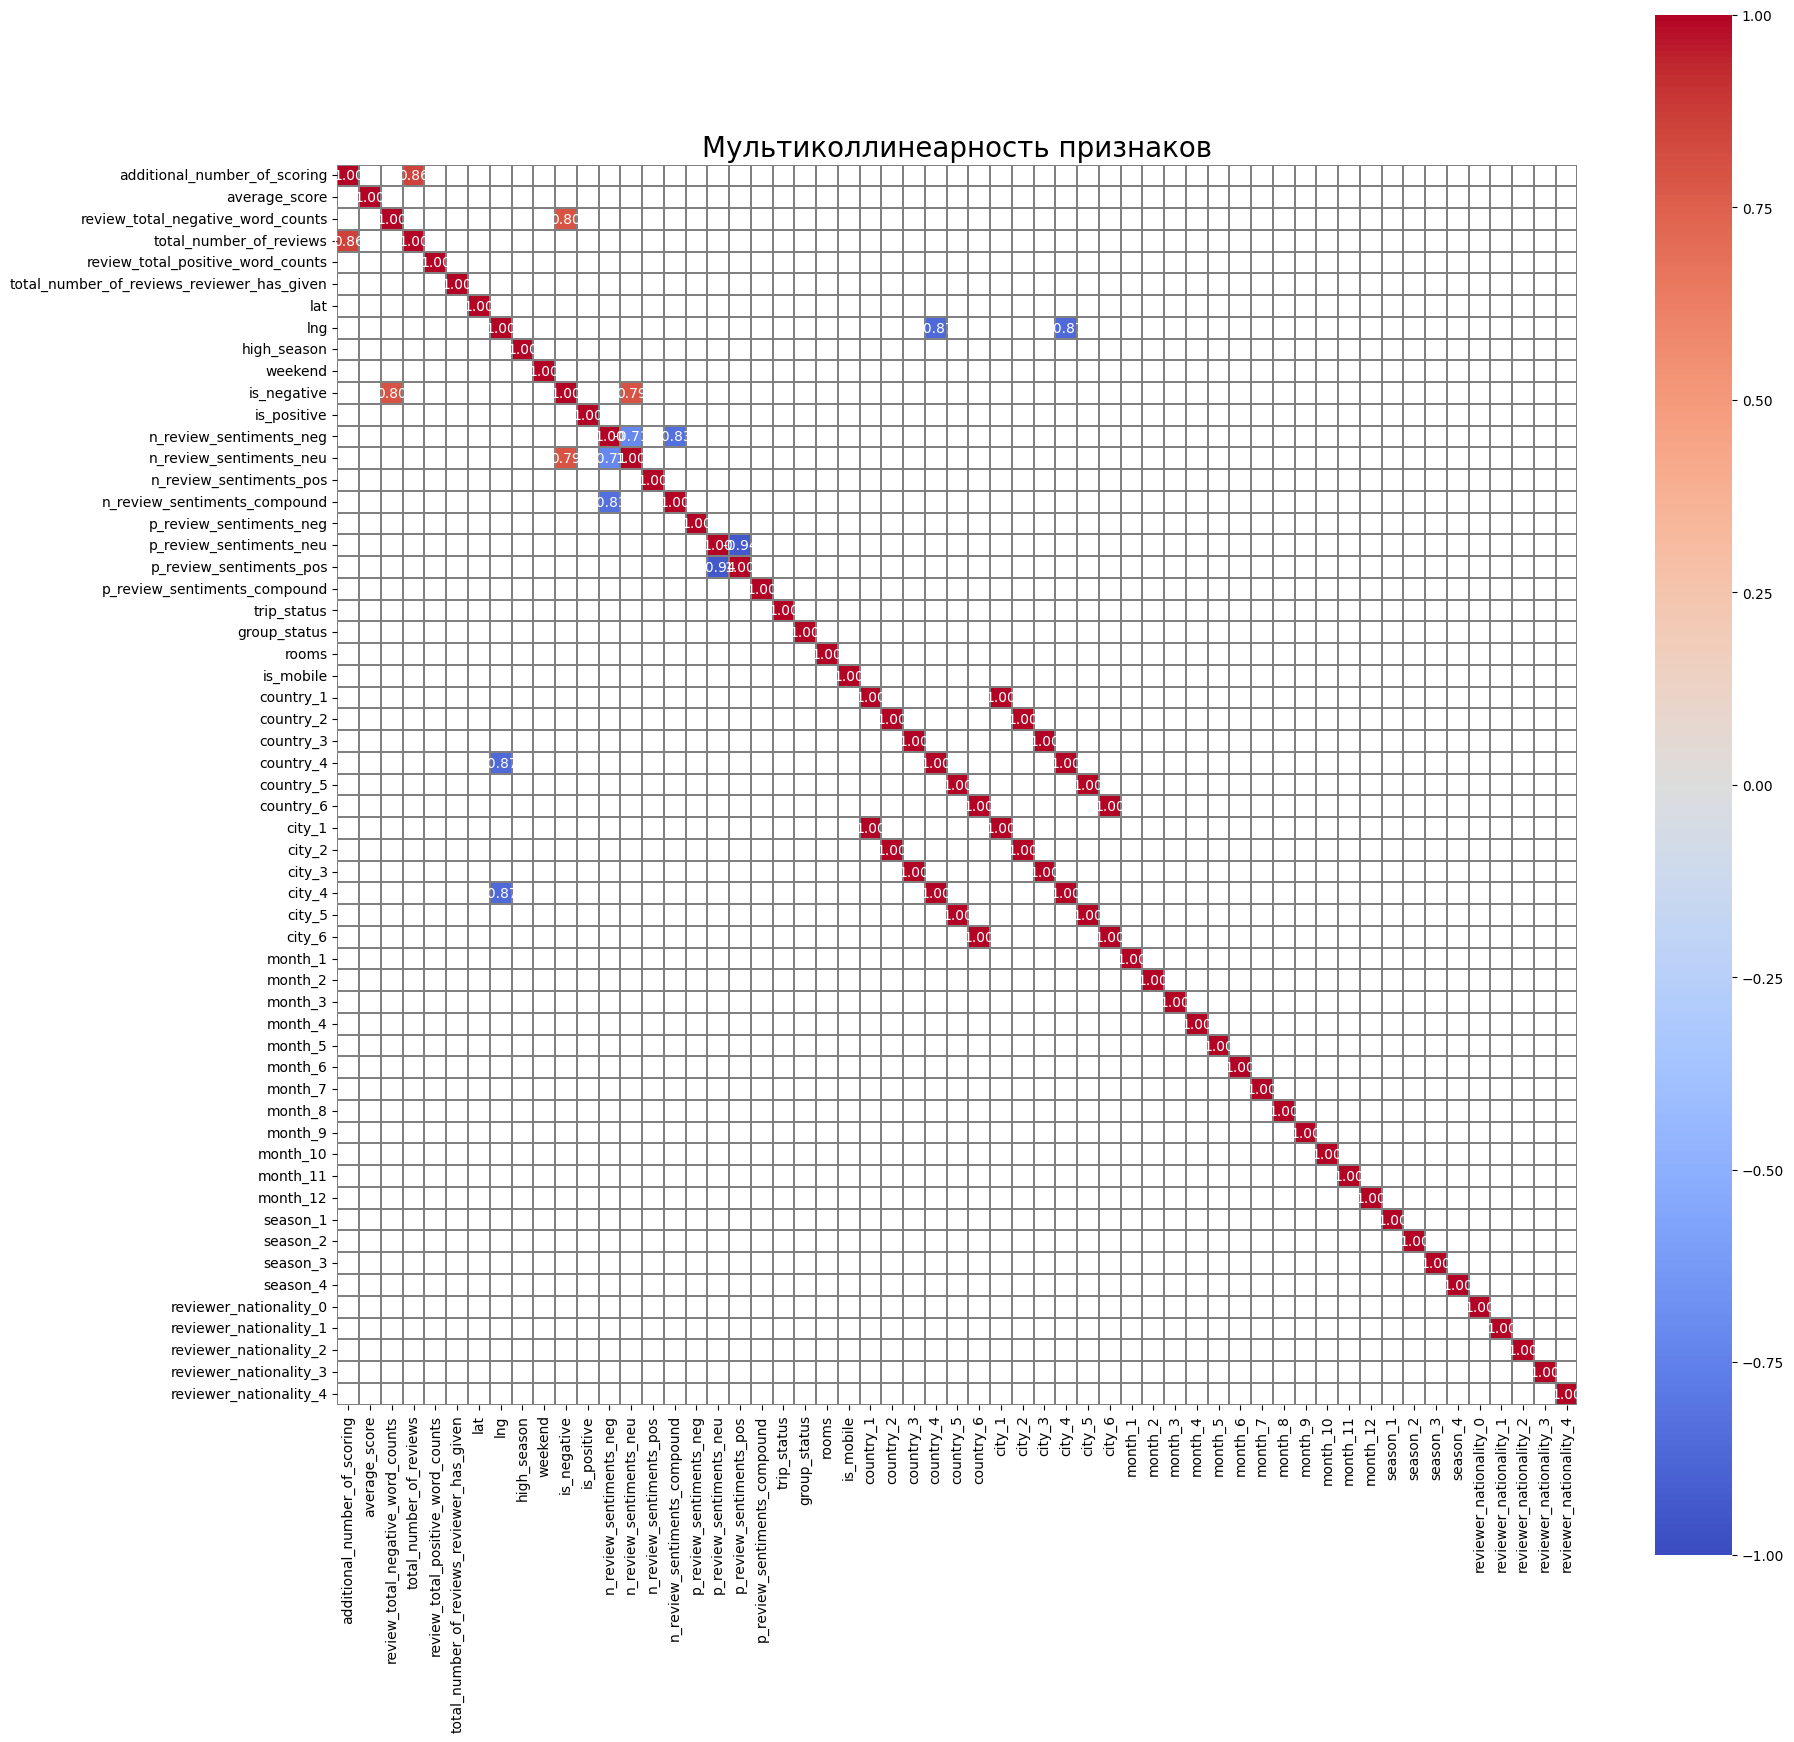

In [63]:
# строим тепловую корреляционную матрицу и анализируем данные на предмет наличия мультиколлинеарности
# используем метод Спирмана, т.к. у нас не только непрерывные переменные

# данные для построения графика
corr = data.drop(['sample', 'reviewer_score'], axis=1).corr(method='spearman')
plt.subplots(figsize=(20, 20))

# выведем только данные с высоким уровнем корреляции
mask_1 = np.abs(corr) >= 0.7
mask_2 = np.abs(corr) <= -0.7
corr_data = corr[mask_1 | mask_2]
 
figure_2 = sns.heatmap(
    corr_data, 
    vmin=-1, 
    vmax=1, 
    linewidth=0.1, 
    linecolor='gray', 
    cmap='coolwarm',
    annot = True,
    fmt='.2f',
    square=True
)

figure_2.set_title('Мультиколлинеарность признаков', fontsize=20);

In [76]:
# рассмотрим признаки, между которыми наблюдается сильная связь
for row in corr_data.index:
    for col in corr_data.columns:
        if corr_data.loc[row, col] != 1 and abs(corr_data.loc[row, col]) >= 0.7:
            print(row, col, '-', round(abs(corr_data.loc[row, col]), 3))

additional_number_of_scoring total_number_of_reviews - 0.859
review_total_negative_word_counts is_negative - 0.797
total_number_of_reviews additional_number_of_scoring - 0.859
is_negative review_total_negative_word_counts - 0.797
is_negative n_review_sentiments_neu - 0.789
n_review_sentiments_neg n_review_sentiments_neu - 0.713
n_review_sentiments_neg n_review_sentiments_compound - 0.829
n_review_sentiments_neu is_negative - 0.789
n_review_sentiments_neu n_review_sentiments_neg - 0.713
n_review_sentiments_compound n_review_sentiments_neg - 0.829
p_review_sentiments_neu p_review_sentiments_pos - 0.939
p_review_sentiments_pos p_review_sentiments_neu - 0.939


In [64]:
# удалим признаки с сильной корреляцией
data.drop(['additional_number_of_scoring', 'review_total_negative_word_counts'], axis=1, inplace=True)

Остальные высококоррелирующие параметры оставлены для построения модели, потому что они созданы в качестве вспомогательных для уточнения и корректировки при построении модели.

## 4.2. Оценка значимости признаков

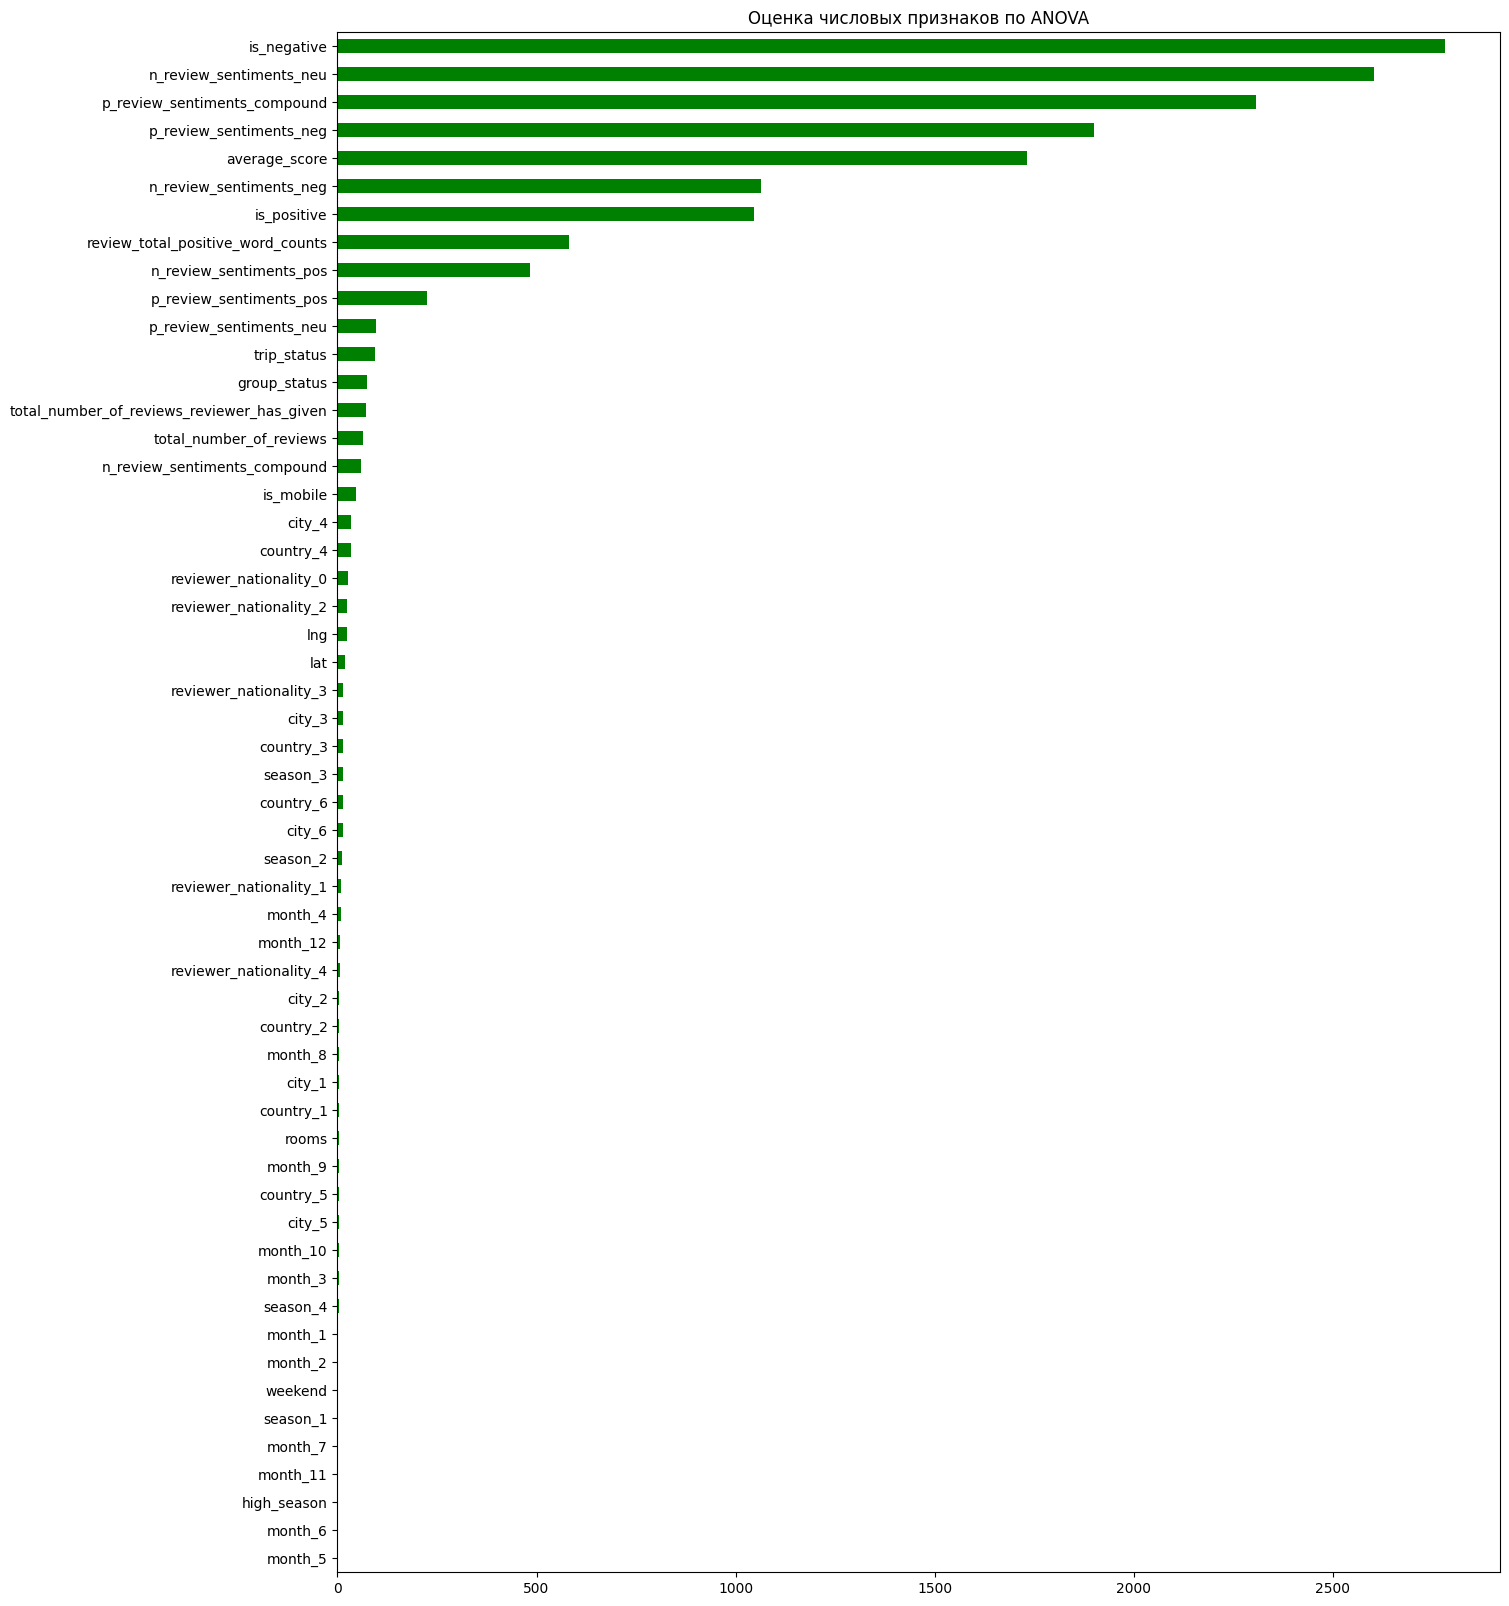

In [65]:
# для оценки значимости непрерывных переменных будем использовать дисперсионный анализ ANOVA
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig, ax = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', title='Оценка числовых признаков по ANOVA', color='green');


In [66]:
cols_to_delete_2 = ['city_1', 'country_1', 'rooms', 'month_9', 'city_5', 'country_5', 'month_10', 'month_3', 'season_4',
                    'month_1', 'month_2', 'weekend', 'season_1', 'month_7', 'month_11', 'high_season', 'month_6', 'month_5']

data.drop(cols_to_delete_2, axis = 1, inplace=True)

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   sample                                      515738 non-null  int64  
 1   reviewer_score                              515738 non-null  float64
 2   average_score                               515738 non-null  float64
 3   total_number_of_reviews                     515738 non-null  float64
 4   review_total_positive_word_counts           515738 non-null  float64
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   is_negative                                 515738 non-null  float64
 9   is_positive                                 515738 non-null  float64
 

In [ ]:
""" Анализ выбросов
#Объявляем функцию, реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned
"""

Пробовала удалить все или часть коррелирующих признаков, оставив те, которые сильнее скоррелированы с зависимой переменной, но метрика изменяется в худшую сторону. Также масштабирование не имеет смысла, метрика не улучшилась, так как RandomForestRegressor не чувствителен к нему.

Что касается выбросов, то после проведения данного анализа, путем построения соответствующих графиков, стало очевидно, что присутствуют значения в десятичном виде - скорее всего это ошибочные данные. Так как их количество невелико, плюс они находятся в допустимом диапазоне, я решила ничего с ними не делать.

## 5. Обучение модели и получение предсказания (Model Building)

In [68]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [69]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [70]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 38), (386803, 38), (386803, 37), (309442, 37), (77361, 37))

In [71]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [72]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [73]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.5s finished


In [74]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', round(metrics.mean_absolute_error(y_test, y_pred), 4))

def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 4))

MAE: 0.8679
MAPE: 12.3365


<AxesSubplot: >

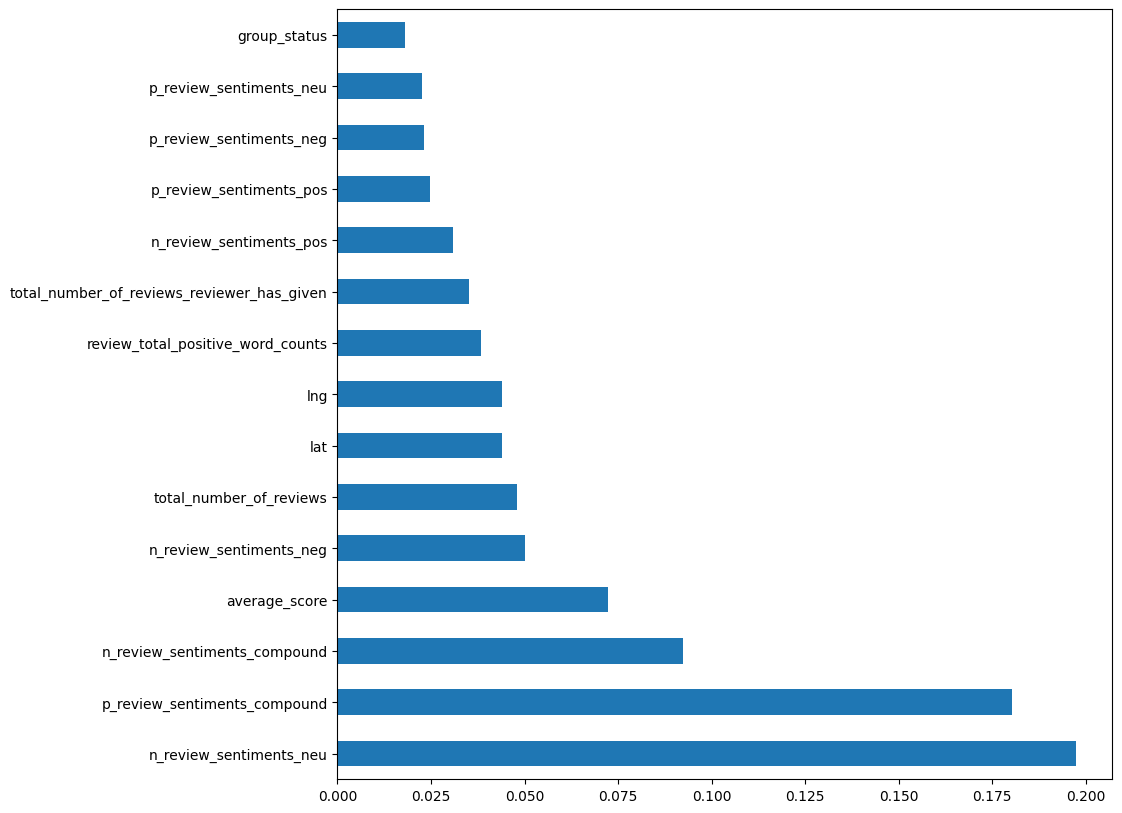

In [75]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [76]:
test_data.sample(10)

,reviewer_score,average_score,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,is_negative,is_positive,n_review_sentiments_neg,...,month_4,month_8,month_12,season_2,season_3,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4
9603,0.0,0.285714,0.224715,-0.411765,0.285714,-0.002990,-0.031702,-1.0,0.0,0.869,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2526,0.0,0.285714,-0.527732,-0.411765,0.142857,-0.996708,3.280651,0.0,0.0,0.014,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
60888,0.0,-0.285714,0.351550,1.882353,-0.285714,0.003880,-0.021002,0.0,0.0,0.146,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19049,0.0,0.000000,0.022431,1.411765,2.428571,-1.820123,1.842053,0.0,0.0,-0.131,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
73219,0.0,0.285714,-0.220228,0.941176,1.285714,-3.061227,0.430429,0.0,0.0,-0.131,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21605,0.0,0.285714,0.099511,0.705882,6.142857,-0.998413,3.281158,-1.0,0.0,0.869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
79679,0.0,0.142857,-0.398042,-0.647059,-0.285714,0.002343,0.000621,0.0,-1.0,-0.131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56963,0.0,-2.142857,1.471452,-0.176471,0.285714,-1.824991,1.817201,0.0,0.0,0.252,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
104306,0.0,-0.428571,-0.342577,1.352941,-0.285714,0.008864,-0.037766,-1.0,0.0,0.869,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
88930,0.0,0.000000,0.808728,1.235294,1.000000,0.004223,-0.024277,0.0,0.0,-0.131,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128935 entries, 0 to 128934
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   reviewer_score                              128935 non-null  float64
 1   average_score                               128935 non-null  float64
 2   total_number_of_reviews                     128935 non-null  float64
 3   review_total_positive_word_counts           128935 non-null  float64
 4   total_number_of_reviews_reviewer_has_given  128935 non-null  float64
 5   lat                                         128935 non-null  float64
 6   lng                                         128935 non-null  float64
 7   is_negative                                 128935 non-null  float64
 8   is_positive                                 128935 non-null  float64
 9   n_review_sentiments_neg                     128935 non-null  float64
 

In [78]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [79]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [80]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.8s finished


In [93]:
predict_submission

array([8.519     , 7.653     , 7.521     , ..., 7.995     , 9.583     ,
       8.03083333])

In [94]:
list(sample_submission)

['reviewer_score', 'id']

In [96]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('final_submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.519,488440
1,7.653,274649
2,7.521,374688
3,9.895,404352
4,9.535,451596
5,8.824,302161
6,6.670,317079
7,7.835,13963
8,8.597,159785
9,7.129,195089


## 6. Вывод

Наиболее значимыми признаками для модели стали: n_review_sentiments_neu, n_review_sentiments_compound, p_review_sentiments_compound, 
average_score, total_number_of_reviews, n_review_sentiments_neg, total_number_of_reviews_reviewer_has_given, p_review_sentiments_neg, p_review_sentiments_neu, p_review_sentiments_pos, n_review_sentiments_pos, trip_status, group_status, is_mobile.

В конечном итоге удалось повысить метрику модели c 0.9822 (baseline) до 0.8679.